In [1]:
import numpy as np
import pandas as pd

def f(x1, x2):
    return (1.3356 * (1.5 * (1 - x1)) 
            + np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2))
            + np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))

def GetGrid(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    y = f(x1, x2)
    return x1, x2, y

def create_dataframe(grid):
   x1, x2, y = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': y.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../../results_f/virtual_samples_RationalQuadratic.xlsx")

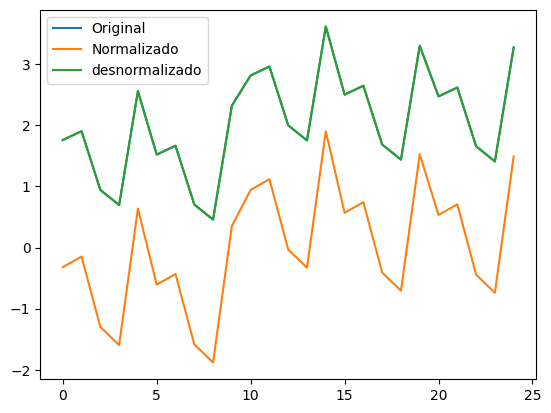

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.lm_model = lm.model.ModelWrapper(self.model)
        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError()
        )

        return(self.lm_model)

2025-07-21 22:27:53.420882: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:27:53.434579: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:27:53.479388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753136873.533796 1472652 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753136873.542137 1472652 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753136873.651576 1472652 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)

    def plot_loss_history(self):
      history = self.results.history
      
      plt.figure(figsize=(8, 5))
      plt.plot(history['loss'], label='Loss de Treinamento')
      plt.plot(history['val_loss'], label='Loss de Validação')
      plt.xlabel('Época')
      plt.ylabel('Loss')
      plt.title('Histórico de Loss')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights("./content/models/initial-weights/initial-.weights.h5")
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
      
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"./content/models/{fileName}.weights.h5"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./content/models/initial-weights/initial-.weights.h5",
                f"./content/models/initial-weights/{fileName}.weights.h5")

  def SaveDataset(self, trainer, fileName):
    path = f"./content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        #trainer.plot_loss_history()
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'./content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando Com amostras virtuais



In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=15)
tester.Loop(sort_by='r2_sup',
            boundarie = 0.5,
            hidden_sizes = [[4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.2, 0.02],
            learning_rate=[0.1, 0.01])

Testando combinacao1: Hidden Size=[4, 2], regularizer=0.2, learning_rate=0.1


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_4,0.956794,0.726505,0.817813,0.948902,0.028871,0.162358,0.155176,0.052536,0.104145,0.169914,0.929097,0.172590,57.089857,111.449539
model_1_0_5,0.962922,0.724096,0.825020,0.954430,0.024776,0.163789,0.149038,0.046852,0.095126,0.157403,0.939154,0.159882,57.395791,111.755473
model_1_0_6,0.967872,0.721336,0.831259,0.958986,0.021468,0.165427,0.143724,0.042168,0.087075,0.146520,0.947277,0.148827,57.682384,112.042065
model_1_0_7,0.971866,0.718326,0.836815,0.962754,0.018799,0.167214,0.138991,0.038294,0.079749,0.137110,0.953831,0.139270,57.947875,112.307556
model_1_0_3,0.890284,0.706859,0.749645,0.884974,0.073312,0.174021,0.213238,0.118262,0.150720,0.270762,0.819954,0.275026,55.226057,109.585738
model_1_0_2,0.879582,0.688412,0.743430,0.879120,0.080464,0.184972,0.218531,0.124281,0.141942,0.283661,0.802391,0.288129,55.039897,109.399579
model_1_0_1,0.849425,0.659557,0.717788,0.861198,0.100615,0.202101,0.240371,0.142707,0.145235,0.317198,0.752902,0.322194,54.592911,108.952593
model_1_0_0,0.716871,0.616771,0.643021,0.762420,0.189188,0.227501,0.304054,0.244264,0.348236,0.434957,0.535378,0.441807,53.330031,107.689713


DataFrame salvo em ./content/results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_9,0.996960,0.750332,0.892846,0.994608,0.002031,0.148214,0.091267,0.003412,0.029207,0.045069,0.995012,0.045779,62.398264,116.757945
model_1_1_7,0.995605,0.747196,0.887572,0.993164,0.002937,0.150076,0.095760,0.004326,0.033844,0.054191,0.992788,0.055045,61.660957,116.020639
model_1_1_8,0.996754,0.745951,0.892633,0.994119,0.002169,0.150815,0.091449,0.003721,0.027499,0.046571,0.994674,0.047304,62.267141,116.626823
model_1_1_6,0.995094,0.742912,0.884796,0.994274,0.003278,0.152619,0.098124,0.003623,0.039626,0.057257,0.991949,0.058158,61.440852,115.800533
model_1_1_5,0.994684,0.736927,0.884573,0.993485,0.003552,0.156171,0.098314,0.004122,0.043176,0.059602,0.991276,0.060541,61.280260,115.639942
model_1_1_4,0.994593,0.732366,0.884175,0.993509,0.003613,0.158879,0.098653,0.004107,0.039117,0.060111,0.991126,0.061057,61.246265,115.605947
model_1_1_3,0.994056,0.727223,0.883099,0.990887,0.003972,0.161932,0.099570,0.005766,0.043169,0.063022,0.990246,0.064015,61.057072,115.416754
model_1_1_2,0.990358,0.721482,0.874603,0.988616,0.006443,0.165340,0.106806,0.007203,0.045903,0.080265,0.984178,0.081529,60.089667,114.449349
model_1_1_0,0.975720,0.717981,0.844177,0.969446,0.016224,0.167418,0.132721,0.019333,0.073422,0.127372,0.960157,0.129378,58.242563,112.602245
model_1_1_1,0.977218,0.716913,0.850534,0.975452,0.015223,0.168053,0.127306,0.015532,0.068356,0.123381,0.962614,0.125324,58.369915,112.729597


DataFrame salvo em ./content/results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_0,0.997528,0.747283,0.894752,0.995487,0.001652,0.150024,0.089644,0.003337,0.024595,0.040645,0.995943,0.041285,62.811534,117.171216
model_1_2_1,0.997934,0.738088,0.894913,0.995109,0.001380,0.155483,0.089507,0.003616,0.019281,0.037155,0.996610,0.037740,63.170662,117.530344
model_1_2_4,0.998173,0.735282,0.894139,0.995067,0.001221,0.157148,0.090166,0.003648,0.018268,0.034945,0.997001,0.035495,63.415970,117.775651
model_1_2_8,0.998556,0.733370,0.896463,0.996076,0.000965,0.158283,0.088187,0.002902,0.014520,0.031060,0.997631,0.031550,63.887280,118.246962
model_1_2_9,0.998591,0.733155,0.896800,0.996194,0.000942,0.158410,0.087899,0.002814,0.014199,0.030687,0.997687,0.031170,63.935728,118.295410
model_1_2_2,0.997921,0.732772,0.894819,0.994857,0.001389,0.158638,0.089587,0.003803,0.017902,0.037273,0.996588,0.037860,63.157989,117.517671
model_1_2_5,0.998338,0.732441,0.895574,0.995580,0.001111,0.158835,0.088944,0.003268,0.015943,0.033325,0.997273,0.033849,63.605846,117.965527
model_1_2_6,0.998464,0.732051,0.896308,0.995875,0.001026,0.159066,0.088318,0.003050,0.014756,0.032034,0.997480,0.032539,63.763772,118.123454
model_1_2_7,0.998528,0.731971,0.896701,0.996040,0.000984,0.159113,0.087984,0.002928,0.014411,0.031363,0.997584,0.031857,63.848459,118.208141
model_1_2_3,0.998109,0.731544,0.895312,0.995128,0.001264,0.159367,0.089167,0.003602,0.016677,0.035548,0.996897,0.036108,63.347449,117.707131


DataFrame salvo em ./content/results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_1,0.998666,0.734527,0.897897,0.998407,0.000892,0.157596,0.086966,0.000975,0.016053,0.029858,0.997811,0.030328,64.045182,118.404864
model_1_3_2,0.998727,0.733284,0.899895,0.998046,0.000851,0.158334,0.085263,0.001195,0.015101,0.029170,0.997910,0.029629,64.138477,118.498159
model_1_3_3,0.998776,0.733077,0.900708,0.997985,0.000818,0.158457,0.084571,0.001233,0.014643,0.028604,0.997991,0.029055,64.216783,118.576464
model_1_3_4,0.998806,0.732832,0.901184,0.997980,0.000798,0.158602,0.084166,0.001236,0.014342,0.028240,0.998041,0.028685,64.268009,118.627691
model_1_3_0,0.998658,0.732782,0.897254,0.999101,0.000897,0.158632,0.087513,0.000550,0.014181,0.029947,0.997798,0.030419,64.033297,118.392979
model_1_3_5,0.998827,0.732732,0.901414,0.997996,0.000784,0.158662,0.083970,0.001226,0.014149,0.028001,0.998074,0.028442,64.302044,118.661725
model_1_3_8,0.998867,0.732666,0.901681,0.998074,0.000757,0.158701,0.083743,0.001179,0.013847,0.027513,0.998141,0.027947,64.372315,118.731997
model_1_3_6,0.998840,0.732652,0.901538,0.998006,0.000775,0.158709,0.083864,0.001220,0.014004,0.027846,0.998096,0.028285,64.324261,118.683942
model_1_3_7,0.998851,0.732578,0.901625,0.998026,0.000767,0.158754,0.083790,0.001208,0.013891,0.027704,0.998115,0.028140,64.344751,118.704433
model_1_3_9,0.998872,0.732561,0.901714,0.998069,0.000754,0.158763,0.083714,0.001182,0.013785,0.027459,0.998148,0.027892,64.380191,118.739873


DataFrame salvo em ./content/results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_4,0.998921,0.738940,0.902121,0.997485,0.000721,0.154976,0.083368,0.001654,0.015018,0.026846,0.998230,0.027269,64.470592,118.830274
model_1_4_5,0.998920,0.738923,0.902262,0.997428,0.000721,0.154986,0.083248,0.001692,0.014804,0.026859,0.998228,0.027282,64.468597,118.828279
model_1_4_6,0.998926,0.738901,0.902347,0.997426,0.000718,0.155000,0.083175,0.001693,0.014745,0.026788,0.998238,0.027209,64.479264,118.838946
model_1_4_3,0.998924,0.738708,0.902294,0.997527,0.000719,0.155114,0.083221,0.001627,0.014893,0.026813,0.998234,0.027235,64.475464,118.835146
model_1_4_7,0.998928,0.738679,0.902499,0.997412,0.000716,0.155131,0.083046,0.001703,0.014618,0.026763,0.998241,0.027185,64.482918,118.842600
model_1_4_8,0.998929,0.738651,0.902544,0.997400,0.000716,0.155148,0.083007,0.001711,0.014578,0.026751,0.998243,0.027172,64.484753,118.844435
model_1_4_9,0.998930,0.738624,0.902604,0.997394,0.000715,0.155164,0.082956,0.001714,0.014531,0.026734,0.998245,0.027155,64.487264,118.846946
model_1_4_2,0.998949,0.737309,0.902413,0.997818,0.000702,0.155944,0.083119,0.001436,0.014726,0.026502,0.998275,0.026920,64.522121,118.881803
model_1_4_1,0.998968,0.735585,0.902713,0.998105,0.000690,0.156968,0.082864,0.001246,0.013981,0.026262,0.998306,0.026675,64.558603,118.918284
model_1_4_0,0.998918,0.733242,0.901899,0.998690,0.000723,0.158359,0.083556,0.000862,0.013801,0.026894,0.998224,0.027318,64.463377,118.823059


DataFrame salvo em ./content/results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_1,0.998845,0.740200,0.898238,0.997295,0.000772,0.154229,0.086675,0.001240,0.014300,0.027779,0.998105,0.028216,64.333940,118.693622
model_1_5_0,0.998930,0.738376,0.902617,0.998036,0.000715,0.155312,0.082945,0.000900,0.014041,0.026737,0.998244,0.027158,64.486811,118.846492
model_1_5_2,0.998966,0.737008,0.899410,0.996873,0.000691,0.156123,0.085677,0.001433,0.011788,0.026282,0.998304,0.026696,64.555484,118.915165
model_1_5_3,0.999016,0.735792,0.899466,0.996844,0.000658,0.156845,0.085629,0.001446,0.011646,0.025644,0.998385,0.026048,64.653809,119.013490
model_1_5_4,0.999015,0.734804,0.899865,0.996698,0.000658,0.157432,0.085289,0.001513,0.011410,0.025659,0.998383,0.026064,64.651367,119.011049
model_1_5_5,0.999013,0.734264,0.900111,0.996642,0.000659,0.157752,0.085079,0.001539,0.011311,0.025675,0.998381,0.026079,64.648980,119.008662
model_1_5_7,0.999012,0.733926,0.900067,0.996617,0.000660,0.157953,0.085117,0.001550,0.011311,0.025688,0.998379,0.026092,64.646969,119.006650
model_1_5_8,0.999009,0.733891,0.899952,0.996573,0.000662,0.157974,0.085215,0.001570,0.011342,0.025737,0.998373,0.026142,64.639351,118.999033
model_1_5_6,0.999009,0.733846,0.900084,0.996604,0.000662,0.158000,0.085102,0.001556,0.011322,0.025735,0.998374,0.026140,64.639667,118.999349
model_1_5_9,0.999011,0.733840,0.899956,0.996588,0.000661,0.158004,0.085211,0.001564,0.011308,0.025702,0.998378,0.026107,64.644769,119.004451


DataFrame salvo em ./content/results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_1,0.998808,0.736276,0.896463,0.996446,0.000796,0.156558,0.088186,0.001927,0.015043,0.028222,0.998044,0.028667,64.270600,118.630282
model_1_6_0,0.999013,0.734560,0.898993,0.997956,0.000659,0.157577,0.086032,0.001108,0.011611,0.025677,0.998381,0.026082,64.648577,119.008259
model_1_6_2,0.998790,0.732958,0.898116,0.995848,0.000808,0.158528,0.086779,0.002251,0.012748,0.028431,0.998015,0.028879,64.241058,118.600740
model_1_6_4,0.998704,0.731934,0.897861,0.995265,0.000866,0.159135,0.086996,0.002567,0.012766,0.029423,0.997874,0.029886,64.103902,118.463584
model_1_6_5,0.998696,0.731867,0.897848,0.995206,0.000872,0.159175,0.087007,0.002600,0.012750,0.029522,0.997860,0.029987,64.090451,118.450133
model_1_6_3,0.998708,0.731639,0.898278,0.995290,0.000863,0.159311,0.086641,0.002554,0.012472,0.029380,0.997880,0.029843,64.109720,118.469402
model_1_6_6,0.998653,0.731367,0.897932,0.994919,0.000900,0.159472,0.086936,0.002755,0.012622,0.030005,0.997789,0.030478,64.025517,118.385199
model_1_6_7,0.998635,0.731247,0.897880,0.994801,0.000912,0.159544,0.086980,0.002819,0.012536,0.030206,0.997759,0.030681,63.998919,118.358601
model_1_6_8,0.998623,0.731218,0.897828,0.994724,0.000920,0.159561,0.087024,0.002861,0.012506,0.030338,0.997740,0.030816,63.981393,118.341075
model_1_6_9,0.998622,0.731203,0.897825,0.994721,0.000921,0.159569,0.087026,0.002862,0.012491,0.030342,0.997739,0.030820,63.980845,118.340527


DataFrame salvo em ./content/results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.998622,0.731203,0.897825,0.999187,0.000921,0.159569,0.087026,0.000684,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_7_1,0.998622,0.731203,0.897825,0.999187,0.000921,0.159569,0.087026,0.000684,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_7_2,0.998622,0.731203,0.897825,0.999187,0.000921,0.159569,0.087026,0.000684,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_7_3,0.998622,0.731203,0.897825,0.999187,0.000921,0.159569,0.087026,0.000684,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_7_4,0.998622,0.731203,0.897825,0.999187,0.000921,0.159569,0.087026,0.000684,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_7_5,0.998622,0.731203,0.897825,0.999187,0.000921,0.159569,0.087026,0.000684,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_7_6,0.998622,0.731203,0.897825,0.999187,0.000921,0.159569,0.087026,0.000684,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_7_7,0.998622,0.731203,0.897825,0.999187,0.000921,0.159569,0.087026,0.000684,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_7_8,0.998622,0.731203,0.897825,0.999187,0.000921,0.159569,0.087026,0.000684,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_7_9,0.998622,0.731203,0.897825,0.999187,0.000921,0.159569,0.087026,0.000684,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527


DataFrame salvo em ./content/results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.998622,0.731203,0.897825,0.996547,0.000921,0.159569,0.087026,0.001481,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_8_1,0.998622,0.731203,0.897825,0.996547,0.000921,0.159569,0.087026,0.001481,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_8_2,0.998622,0.731203,0.897825,0.996547,0.000921,0.159569,0.087026,0.001481,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_8_3,0.998622,0.731203,0.897825,0.996547,0.000921,0.159569,0.087026,0.001481,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_8_4,0.998622,0.731203,0.897825,0.996547,0.000921,0.159569,0.087026,0.001481,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_8_5,0.998622,0.731203,0.897825,0.996547,0.000921,0.159569,0.087026,0.001481,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_8_6,0.998622,0.731203,0.897825,0.996547,0.000921,0.159569,0.087026,0.001481,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_8_7,0.998622,0.731203,0.897825,0.996547,0.000921,0.159569,0.087026,0.001481,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_8_8,0.998622,0.731203,0.897825,0.996547,0.000921,0.159569,0.087026,0.001481,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_8_9,0.998622,0.731203,0.897825,0.996547,0.000921,0.159569,0.087026,0.001481,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527


DataFrame salvo em ./content/results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_0,0.998622,0.731203,0.897825,0.997807,0.000921,0.159569,0.087026,0.000834,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_9_1,0.998622,0.731203,0.897825,0.997807,0.000921,0.159569,0.087026,0.000834,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_9_2,0.998622,0.731203,0.897825,0.997807,0.000921,0.159569,0.087026,0.000834,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_9_3,0.998622,0.731203,0.897825,0.997807,0.000921,0.159569,0.087026,0.000834,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_9_4,0.998622,0.731203,0.897825,0.997807,0.000921,0.159569,0.087026,0.000834,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_9_5,0.998622,0.731203,0.897825,0.997807,0.000921,0.159569,0.087026,0.000834,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_9_6,0.998622,0.731203,0.897825,0.997807,0.000921,0.159569,0.087026,0.000834,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_9_7,0.998622,0.731203,0.897825,0.997807,0.000921,0.159569,0.087026,0.000834,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_9_8,0.998622,0.731203,0.897825,0.997807,0.000921,0.159569,0.087026,0.000834,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_9_9,0.998622,0.731203,0.897825,0.997807,0.000921,0.159569,0.087026,0.000834,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527


DataFrame salvo em ./content/results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_0,0.998622,0.731203,0.897825,0.998446,0.000921,0.159569,0.087026,0.001183,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_10_1,0.998622,0.731203,0.897825,0.998446,0.000921,0.159569,0.087026,0.001183,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_10_2,0.998622,0.731203,0.897825,0.998446,0.000921,0.159569,0.087026,0.001183,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_10_3,0.998622,0.731203,0.897825,0.998446,0.000921,0.159569,0.087026,0.001183,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_10_4,0.998622,0.731203,0.897825,0.998446,0.000921,0.159569,0.087026,0.001183,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_10_5,0.998622,0.731203,0.897825,0.998446,0.000921,0.159569,0.087026,0.001183,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_10_6,0.998622,0.731203,0.897825,0.998446,0.000921,0.159569,0.087026,0.001183,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_10_7,0.998622,0.731203,0.897825,0.998446,0.000921,0.159569,0.087026,0.001183,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_10_8,0.998622,0.731203,0.897825,0.998446,0.000921,0.159569,0.087026,0.001183,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_10_9,0.998622,0.731203,0.897825,0.998446,0.000921,0.159569,0.087026,0.001183,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527


DataFrame salvo em ./content/results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_0,0.998622,0.731203,0.897825,0.996432,0.000921,0.159569,0.087026,0.002169,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_11_1,0.998622,0.731203,0.897825,0.996432,0.000921,0.159569,0.087026,0.002169,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_11_2,0.998622,0.731203,0.897825,0.996432,0.000921,0.159569,0.087026,0.002169,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_11_3,0.998622,0.731203,0.897825,0.996432,0.000921,0.159569,0.087026,0.002169,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_11_4,0.998622,0.731203,0.897825,0.996432,0.000921,0.159569,0.087026,0.002169,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_11_5,0.998622,0.731203,0.897825,0.996432,0.000921,0.159569,0.087026,0.002169,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_11_6,0.998622,0.731203,0.897825,0.996432,0.000921,0.159569,0.087026,0.002169,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_11_7,0.998622,0.731203,0.897825,0.996432,0.000921,0.159569,0.087026,0.002169,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_11_8,0.998622,0.731203,0.897825,0.996432,0.000921,0.159569,0.087026,0.002169,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_11_9,0.998622,0.731203,0.897825,0.996432,0.000921,0.159569,0.087026,0.002169,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527


DataFrame salvo em ./content/results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.998622,0.731203,0.897825,0.999003,0.000921,0.159569,0.087026,0.000839,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_12_1,0.998622,0.731203,0.897825,0.999003,0.000921,0.159569,0.087026,0.000839,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_12_2,0.998622,0.731203,0.897825,0.999003,0.000921,0.159569,0.087026,0.000839,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_12_3,0.998622,0.731203,0.897825,0.999003,0.000921,0.159569,0.087026,0.000839,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_12_4,0.998622,0.731203,0.897825,0.999003,0.000921,0.159569,0.087026,0.000839,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_12_5,0.998622,0.731203,0.897825,0.999003,0.000921,0.159569,0.087026,0.000839,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_12_6,0.998622,0.731203,0.897825,0.999003,0.000921,0.159569,0.087026,0.000839,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_12_7,0.998622,0.731203,0.897825,0.999003,0.000921,0.159569,0.087026,0.000839,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_12_8,0.998622,0.731203,0.897825,0.999003,0.000921,0.159569,0.087026,0.000839,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_12_9,0.998622,0.731203,0.897825,0.999003,0.000921,0.159569,0.087026,0.000839,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527


DataFrame salvo em ./content/results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.998622,0.731203,0.897825,0.998662,0.000921,0.159569,0.087026,0.000674,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_13_1,0.998622,0.731203,0.897825,0.998662,0.000921,0.159569,0.087026,0.000674,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_13_2,0.998622,0.731203,0.897825,0.998662,0.000921,0.159569,0.087026,0.000674,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_13_3,0.998622,0.731203,0.897825,0.998662,0.000921,0.159569,0.087026,0.000674,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_13_4,0.998622,0.731203,0.897825,0.998662,0.000921,0.159569,0.087026,0.000674,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_13_5,0.998622,0.731203,0.897825,0.998662,0.000921,0.159569,0.087026,0.000674,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_13_6,0.998622,0.731203,0.897825,0.998662,0.000921,0.159569,0.087026,0.000674,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_13_7,0.998622,0.731203,0.897825,0.998662,0.000921,0.159569,0.087026,0.000674,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_13_8,0.998622,0.731203,0.897825,0.998662,0.000921,0.159569,0.087026,0.000674,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_13_9,0.998622,0.731203,0.897825,0.998662,0.000921,0.159569,0.087026,0.000674,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527


DataFrame salvo em ./content/results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_0,0.998622,0.731203,0.897825,0.998517,0.000921,0.159569,0.087026,0.000724,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_14_1,0.998622,0.731203,0.897825,0.998517,0.000921,0.159569,0.087026,0.000724,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_14_2,0.998622,0.731203,0.897825,0.998517,0.000921,0.159569,0.087026,0.000724,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_14_3,0.998622,0.731203,0.897825,0.998517,0.000921,0.159569,0.087026,0.000724,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_14_4,0.998622,0.731203,0.897825,0.998517,0.000921,0.159569,0.087026,0.000724,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_14_5,0.998622,0.731203,0.897825,0.998517,0.000921,0.159569,0.087026,0.000724,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_14_6,0.998622,0.731203,0.897825,0.998517,0.000921,0.159569,0.087026,0.000724,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_14_7,0.998622,0.731203,0.897825,0.998517,0.000921,0.159569,0.087026,0.000724,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_14_8,0.998622,0.731203,0.897825,0.998517,0.000921,0.159569,0.087026,0.000724,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527
model_1_14_9,0.998622,0.731203,0.897825,0.998517,0.000921,0.159569,0.087026,0.000724,0.012491,0.030342,0.997739,0.03082,63.980845,118.340527


DataFrame salvo em ./content/results/metrics_1_14
Testando combinacao2: Hidden Size=[4, 2], regularizer=0.2, learning_rate=0.01


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_6,0.669786,0.575446,0.546782,0.245425,0.220650,0.252033,0.386024,0.192436,0.350829,0.469734,0.458110,0.477132,53.022357,107.382038
model_2_2_7,0.672881,0.571690,0.551461,0.248603,0.218582,0.254263,0.382039,0.191625,0.350155,0.467527,0.463189,0.474890,53.041190,107.400872
model_2_2_5,0.662832,0.569483,0.539869,0.230058,0.225297,0.255574,0.391913,0.196355,0.354976,0.474654,0.446698,0.482129,52.980675,107.340357
model_2_2_8,0.675881,0.567558,0.556602,0.257400,0.216577,0.256716,0.377660,0.189382,0.350581,0.465379,0.468112,0.472708,53.059614,107.419296
model_2_2_4,0.656548,0.565250,0.533114,0.213154,0.229496,0.258086,0.397666,0.200666,0.357651,0.479057,0.436386,0.486602,52.943744,107.303425
model_2_2_3,0.643388,0.554433,0.519666,0.181451,0.238289,0.264508,0.409120,0.208751,0.364396,0.488149,0.414790,0.495837,52.868540,107.228221
model_2_2_1,0.629376,0.548177,0.507183,0.273670,0.247652,0.268222,0.419752,0.185233,0.387924,0.497646,0.391797,0.505484,52.791462,107.151144
model_2_2_2,0.643371,0.537891,0.524501,0.209551,0.238300,0.274328,0.405002,0.201585,0.372290,0.488160,0.414763,0.495848,52.868449,107.228131
model_2_2_0,0.613910,0.523630,0.495012,0.258340,0.257987,0.282794,0.430119,0.189142,0.399775,0.507924,0.366416,0.515923,52.709695,107.069377


DataFrame salvo em ./content/results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_8,0.816572,0.693544,0.691739,0.803019,0.122567,0.181926,0.262558,0.112423,0.246803,0.350096,0.698990,0.355609,54.198194,108.557876
model_2_3_9,0.826533,0.680586,0.705100,0.819730,0.115911,0.189618,0.251178,0.102886,0.243963,0.340457,0.715337,0.345819,54.309869,108.669550
model_2_3_7,0.792967,0.680149,0.667134,0.778531,0.138340,0.189877,0.283515,0.126400,0.265454,0.371941,0.660253,0.377799,53.956079,108.315761
model_2_3_6,0.788967,0.678334,0.662888,0.773678,0.141013,0.190955,0.287132,0.129170,0.267524,0.375517,0.653689,0.381431,53.917806,108.277487
model_2_3_5,0.784849,0.676195,0.658622,0.768776,0.143764,0.192225,0.290766,0.131967,0.269641,0.379163,0.646932,0.385134,53.879161,108.238843
model_2_3_4,0.782847,0.676075,0.656540,0.767163,0.145102,0.192296,0.292539,0.132887,0.271995,0.380923,0.643647,0.386922,53.860635,108.220317
model_2_3_3,0.763973,0.669961,0.636540,0.745216,0.157714,0.195926,0.309573,0.145414,0.287037,0.397132,0.612673,0.403387,53.693945,108.053627
model_2_3_1,0.730152,0.646622,0.602471,0.707998,0.180313,0.209781,0.338592,0.166655,0.310703,0.424633,0.557172,0.431321,53.426119,107.785800
model_2_3_2,0.734066,0.645162,0.607098,0.714386,0.177697,0.210647,0.334650,0.163009,0.309796,0.421542,0.563596,0.428181,53.455345,107.815027
model_2_3_0,0.706611,0.591094,0.586116,0.693589,0.196043,0.242744,0.352522,0.174879,0.332823,0.442767,0.518542,0.449741,53.258843,107.618525


DataFrame salvo em ./content/results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_9,0.899087,0.743318,0.781117,0.869447,0.067430,0.152377,0.186431,0.058148,0.173794,0.259673,0.834400,0.263763,55.393326,109.753008
model_2_4_8,0.886861,0.736247,0.767463,0.855616,0.075599,0.156575,0.198061,0.064308,0.184521,0.274954,0.814337,0.279284,55.164613,109.524295
model_2_4_7,0.884693,0.735328,0.765017,0.853638,0.077048,0.157121,0.200144,0.065189,0.186248,0.277576,0.810778,0.281947,55.126644,109.486325
model_2_4_6,0.882898,0.734849,0.762953,0.852365,0.078248,0.157405,0.201903,0.065756,0.187933,0.279728,0.807832,0.284134,55.095746,109.455428
model_2_4_5,0.880667,0.733910,0.760463,0.850341,0.079739,0.157962,0.204024,0.066657,0.189715,0.282380,0.804171,0.286828,55.058001,109.417683
model_2_4_4,0.878546,0.733209,0.758073,0.848701,0.081156,0.158378,0.206059,0.067387,0.191416,0.284879,0.800691,0.289365,55.022770,109.382452
model_2_4_2,0.874755,0.731317,0.753805,0.845069,0.083689,0.159502,0.209695,0.069005,0.194608,0.289291,0.794470,0.293847,54.961293,109.320975
model_2_4_3,0.876710,0.731073,0.756084,0.845196,0.082382,0.159647,0.207753,0.068949,0.193384,0.287023,0.797679,0.291544,54.992766,109.352447
model_2_4_1,0.870267,0.729374,0.748797,0.841108,0.086688,0.160655,0.213960,0.070770,0.197954,0.294428,0.787105,0.299065,54.890880,109.250562
model_2_4_0,0.848584,0.713815,0.725334,0.814631,0.101177,0.169892,0.233944,0.082562,0.216866,0.318083,0.751522,0.323092,54.581775,108.941457


DataFrame salvo em ./content/results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_9,0.929102,0.744980,0.818662,0.932974,0.047374,0.151391,0.154453,0.048308,0.144227,0.217657,0.883654,0.221085,56.099346,110.459027
model_2_5_0,0.901064,0.744207,0.783388,0.904372,0.066110,0.151850,0.184497,0.068923,0.172092,0.257118,0.837643,0.261167,55.432883,109.792565
model_2_5_2,0.905824,0.743912,0.789204,0.908910,0.062928,0.152025,0.179544,0.065652,0.168159,0.250856,0.845455,0.254806,55.531513,109.891194
model_2_5_7,0.923699,0.743174,0.812248,0.928811,0.050985,0.152463,0.159916,0.051308,0.148752,0.225798,0.874788,0.229354,55.952458,110.312140
model_2_5_1,0.903821,0.742990,0.786858,0.906659,0.064267,0.152572,0.181542,0.067274,0.170154,0.253510,0.842167,0.257502,55.489411,109.849093
model_2_5_3,0.907575,0.742784,0.791538,0.911039,0.061759,0.152694,0.177555,0.064118,0.166215,0.248513,0.848327,0.252427,55.569034,109.928716
model_2_5_6,0.922172,0.742673,0.810432,0.927312,0.052005,0.152761,0.161463,0.052389,0.150256,0.228045,0.872283,0.231637,55.912847,110.272529
model_2_5_8,0.924845,0.742562,0.813794,0.929996,0.050219,0.152827,0.158599,0.050455,0.147420,0.224096,0.876668,0.227625,55.982724,110.342405
model_2_5_5,0.920558,0.742140,0.808475,0.925632,0.053083,0.153077,0.163129,0.053600,0.151910,0.230398,0.869634,0.234027,55.871789,110.231470
model_2_5_4,0.918948,0.741744,0.806504,0.923939,0.054159,0.153312,0.164808,0.054820,0.153574,0.232721,0.866992,0.236386,55.831659,110.191341


DataFrame salvo em ./content/results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_9,0.962116,0.752356,0.862042,0.979523,0.025314,0.147012,0.117504,0.011938,0.096318,0.159104,0.937831,0.161610,57.352779,111.712460
model_2_6_8,0.952144,0.741394,0.851467,0.976303,0.031978,0.153520,0.126512,0.013815,0.101193,0.178823,0.921467,0.181639,56.885436,111.245118
model_2_6_4,0.948286,0.739267,0.846817,0.972885,0.034556,0.154782,0.130472,0.015809,0.107827,0.185891,0.915136,0.188819,56.730373,111.090055
model_2_6_6,0.949886,0.739146,0.848930,0.973596,0.033486,0.154854,0.128673,0.015394,0.105675,0.182993,0.917761,0.185875,56.793231,111.152912
model_2_6_7,0.950604,0.739093,0.849835,0.973838,0.033007,0.154885,0.127902,0.015253,0.104819,0.181678,0.918939,0.184539,56.822080,111.181762
model_2_6_3,0.947357,0.738933,0.845727,0.972471,0.035176,0.154981,0.131401,0.016050,0.108799,0.187553,0.913612,0.190507,56.694779,111.054461
model_2_6_5,0.949047,0.738918,0.847925,0.973223,0.034047,0.154989,0.129529,0.015611,0.106619,0.184518,0.916385,0.187424,56.760025,111.119706
model_2_6_2,0.943868,0.737583,0.841536,0.970824,0.037507,0.155782,0.134970,0.017010,0.112671,0.193668,0.907887,0.196718,56.566440,110.926122
model_2_6_1,0.942951,0.737523,0.840407,0.970508,0.038121,0.155818,0.135932,0.017194,0.113614,0.195245,0.906380,0.198320,56.534001,110.893682
model_2_6_0,0.935766,0.736453,0.831026,0.966277,0.042921,0.156453,0.143923,0.019661,0.123006,0.207175,0.894590,0.210438,56.296767,110.656448


DataFrame salvo em ./content/results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_2,0.970114,0.768685,0.868416,0.972028,0.019970,0.137319,0.112075,0.019675,0.098132,0.141315,0.950956,0.143540,57.827065,112.186747
model_2_7_6,0.973624,0.765424,0.874281,0.975844,0.017624,0.139255,0.107080,0.016991,0.095666,0.132757,0.956717,0.134848,58.076947,112.436629
model_2_7_4,0.972956,0.765322,0.873485,0.975124,0.018071,0.139315,0.107758,0.017497,0.097114,0.134427,0.955621,0.136544,58.026939,112.386620
model_2_7_5,0.973339,0.765246,0.873972,0.975524,0.017815,0.139360,0.107344,0.017216,0.096191,0.133474,0.956248,0.135576,58.055401,112.415083
model_2_7_3,0.972816,0.763555,0.873584,0.974905,0.018165,0.140364,0.107674,0.017651,0.097448,0.134776,0.955390,0.136898,58.016571,112.376253
model_2_7_9,0.980717,0.762509,0.885717,0.983086,0.012885,0.140985,0.097340,0.011896,0.073771,0.113512,0.968356,0.115300,58.703379,113.063061
model_2_7_8,0.980489,0.762400,0.885437,0.982823,0.013037,0.141050,0.097578,0.012082,0.074131,0.114180,0.967983,0.115978,58.679922,113.039603
model_2_7_7,0.978168,0.762333,0.882132,0.980148,0.014588,0.141090,0.100393,0.013964,0.078682,0.120780,0.964174,0.122682,58.455129,112.814811
model_2_7_1,0.968728,0.762234,0.868251,0.970276,0.020896,0.141148,0.112216,0.020907,0.099378,0.144554,0.948682,0.146831,57.736401,112.096082
model_2_7_0,0.968155,0.762131,0.867510,0.969624,0.021279,0.141210,0.112847,0.021366,0.100344,0.145873,0.947741,0.148170,57.700076,112.059758


DataFrame salvo em ./content/results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_2,0.986749,0.755826,0.902961,0.980916,0.008854,0.144952,0.082652,0.007686,0.051402,0.094096,0.978255,0.095578,59.453739,113.813420
model_2_8_3,0.988136,0.752724,0.904734,0.982438,0.007928,0.146794,0.081142,0.007073,0.047367,0.089037,0.980531,0.090439,59.674811,114.034493
model_2_8_1,0.985822,0.752292,0.903661,0.978291,0.009474,0.147050,0.082056,0.008744,0.048773,0.097335,0.976733,0.098868,59.318388,113.678070
model_2_8_0,0.985647,0.752283,0.903536,0.978042,0.009591,0.147056,0.082162,0.008844,0.048996,0.097933,0.976446,0.099475,59.293894,113.653575
model_2_8_4,0.989966,0.751982,0.905186,0.985812,0.006705,0.147234,0.080757,0.005715,0.047295,0.081882,0.983534,0.083171,60.009912,114.369594
model_2_8_5,0.990109,0.751637,0.905166,0.986162,0.006609,0.147439,0.080774,0.005574,0.047521,0.081298,0.983768,0.082578,60.038532,114.398214
model_2_8_6,0.990183,0.750953,0.905273,0.986205,0.006560,0.147845,0.080683,0.005556,0.047085,0.080994,0.983889,0.082270,60.053522,114.413203
model_2_8_8,0.990489,0.750765,0.905325,0.986629,0.006355,0.147957,0.080638,0.005386,0.047184,0.079721,0.984392,0.080976,60.116912,114.476594
model_2_8_9,0.990591,0.750600,0.905404,0.986674,0.006287,0.148055,0.080571,0.005368,0.046902,0.079293,0.984559,0.080541,60.138444,114.498126
model_2_8_7,0.990406,0.750335,0.905525,0.986354,0.006411,0.148212,0.080468,0.005496,0.046387,0.080066,0.984256,0.081327,60.099603,114.459285


DataFrame salvo em ./content/results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_1,0.991558,0.749834,0.906051,0.983349,0.005641,0.148509,0.080020,0.008486,0.044043,0.075107,0.986146,0.076290,60.355383,114.715065
model_2_9_0,0.991459,0.749624,0.906052,0.983302,0.005707,0.148634,0.080019,0.008510,0.044368,0.075544,0.985984,0.076734,60.332139,114.691821
model_2_9_2,0.991611,0.749565,0.906075,0.983360,0.005606,0.148669,0.080000,0.008480,0.044414,0.074871,0.986233,0.076050,60.367948,114.727630
model_2_9_3,0.991676,0.749096,0.906219,0.983359,0.005562,0.148947,0.079877,0.008481,0.043968,0.074581,0.986339,0.075756,60.383453,114.743135
model_2_9_4,0.992322,0.748096,0.906779,0.983730,0.005130,0.149541,0.079401,0.008292,0.040728,0.071626,0.987401,0.072754,60.545169,114.904851
model_2_9_5,0.992357,0.747734,0.906848,0.983690,0.005107,0.149756,0.079341,0.008312,0.040439,0.071464,0.987458,0.072590,60.554243,114.913925
model_2_9_6,0.992406,0.747503,0.906790,0.983706,0.005074,0.149893,0.079391,0.008304,0.041080,0.071234,0.987538,0.072356,60.567124,114.926806
model_2_9_8,0.992740,0.745644,0.907179,0.983498,0.004851,0.150997,0.079060,0.008410,0.040196,0.069648,0.988087,0.070745,60.657182,115.016864
model_2_9_7,0.992748,0.745517,0.907295,0.983578,0.004846,0.151072,0.078960,0.008369,0.040192,0.069613,0.988099,0.070709,60.659211,115.018892
model_2_9_9,0.993166,0.745507,0.906943,0.983874,0.004566,0.151078,0.079261,0.008218,0.039411,0.067574,0.988786,0.068638,60.778135,115.137816


DataFrame salvo em ./content/results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_3,0.993818,0.749062,0.907023,0.989288,0.004131,0.148968,0.079192,0.004722,0.039661,0.064272,0.989855,0.065284,60.978519,115.338201
model_2_10_4,0.993829,0.748731,0.907094,0.989327,0.004123,0.149164,0.079132,0.004705,0.039649,0.064212,0.989874,0.065223,60.982277,115.341959
model_2_10_5,0.994086,0.747491,0.907716,0.989529,0.003952,0.149900,0.078602,0.004616,0.037633,0.062861,0.990296,0.063851,61.067304,115.426986
model_2_10_1,0.993602,0.747198,0.907262,0.989878,0.004275,0.150074,0.078989,0.004462,0.040612,0.065384,0.989501,0.066414,60.909923,115.269604
model_2_10_2,0.993625,0.747163,0.907285,0.989864,0.004260,0.150095,0.078969,0.004468,0.040526,0.065267,0.989538,0.066295,60.917076,115.276758
model_2_10_0,0.993338,0.745043,0.907324,0.990863,0.004451,0.151354,0.078936,0.004028,0.038165,0.066718,0.989068,0.067769,60.829132,115.188814
model_2_10_9,0.994681,0.743004,0.909187,0.990051,0.003554,0.152564,0.077349,0.004386,0.032240,0.059617,0.991271,0.060556,61.279264,115.638946
model_2_10_6,0.994383,0.742691,0.909469,0.990680,0.003753,0.152750,0.077109,0.004109,0.032385,0.061265,0.990782,0.062230,61.170183,115.529865
model_2_10_8,0.994636,0.742158,0.909547,0.990417,0.003584,0.153066,0.077042,0.004225,0.031770,0.059870,0.991197,0.060813,61.262294,115.621976
model_2_10_7,0.994539,0.741597,0.909512,0.990600,0.003649,0.153399,0.077072,0.004144,0.032329,0.060408,0.991038,0.061359,61.226543,115.586225


DataFrame salvo em ./content/results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_11_0,0.994694,0.742781,0.909197,0.995498,0.003545,0.152696,0.077341,0.005091,0.032148,0.059544,0.991293,0.060482,61.284157,115.643839
model_2_11_1,0.994710,0.742595,0.909198,0.995510,0.003535,0.152807,0.077340,0.005078,0.032031,0.059454,0.991319,0.060390,61.290217,115.649899
model_2_11_2,0.994702,0.742489,0.909155,0.995482,0.003540,0.152869,0.077376,0.005109,0.032301,0.059498,0.991306,0.060435,61.287225,115.646907
model_2_11_7,0.994776,0.740950,0.908282,0.995314,0.003491,0.153783,0.078120,0.005300,0.031788,0.059082,0.991427,0.060012,61.315325,115.675007
model_2_11_8,0.994812,0.740373,0.908149,0.995328,0.003467,0.154126,0.078233,0.005284,0.031534,0.058881,0.991486,0.059808,61.328958,115.688640
model_2_11_9,0.994819,0.740260,0.908122,0.995329,0.003462,0.154193,0.078256,0.005283,0.031472,0.058838,0.991498,0.059764,61.331879,115.691561
model_2_11_3,0.994824,0.739782,0.909298,0.995616,0.003459,0.154477,0.077254,0.004958,0.030981,0.058812,0.991506,0.059738,61.333655,115.693336
model_2_11_4,0.994859,0.739160,0.909316,0.995639,0.003435,0.154846,0.077240,0.004932,0.030595,0.058609,0.991564,0.059532,61.347470,115.707152
model_2_11_5,0.994872,0.738653,0.909402,0.995667,0.003426,0.155147,0.077166,0.004901,0.030285,0.058534,0.991586,0.059456,61.352592,115.712273
model_2_11_6,0.994881,0.738475,0.909407,0.995668,0.003421,0.155253,0.077162,0.004899,0.030217,0.058486,0.991599,0.059407,61.355882,115.715564


DataFrame salvo em ./content/results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_12_5,0.994676,0.743630,0.905654,0.993950,0.003558,0.152192,0.080358,0.007115,0.031159,0.059646,0.991263,0.060586,61.277280,115.636962
model_2_12_0,0.994781,0.742316,0.907302,0.994545,0.003487,0.152972,0.078955,0.006416,0.031600,0.059055,0.991435,0.059985,61.317154,115.676836
model_2_12_1,0.994784,0.741765,0.907074,0.994477,0.003486,0.153300,0.079149,0.006496,0.031262,0.059039,0.991440,0.059968,61.318250,115.677931
model_2_12_2,0.994785,0.741724,0.906953,0.994448,0.003485,0.153324,0.079252,0.006530,0.031202,0.059031,0.991442,0.059961,61.318752,115.678434
model_2_12_3,0.994797,0.741637,0.906765,0.994355,0.003477,0.153376,0.079412,0.006639,0.030832,0.058966,0.991461,0.059895,61.323180,115.682862
model_2_12_4,0.994794,0.741549,0.906690,0.994336,0.003478,0.153427,0.079476,0.006661,0.030795,0.058977,0.991458,0.059906,61.322399,115.682081
model_2_12_6,0.994763,0.741088,0.905713,0.993938,0.003499,0.153701,0.080308,0.007129,0.030356,0.059153,0.991407,0.060084,61.310532,115.670214
model_2_12_7,0.994861,0.737322,0.906953,0.993949,0.003434,0.155937,0.079252,0.007116,0.029728,0.058599,0.991567,0.059522,61.348142,115.707824
model_2_12_8,0.994854,0.737294,0.906952,0.993915,0.003439,0.155954,0.079253,0.007157,0.029736,0.058642,0.991555,0.059565,61.345242,115.704923
model_2_12_9,0.994850,0.737250,0.906880,0.993891,0.003442,0.155980,0.079314,0.007185,0.029762,0.058665,0.991548,0.059589,61.343663,115.703344


DataFrame salvo em ./content/results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  19
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  18
3/3 ━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_13_2,0.995007,0.737241,0.906864,0.994002,0.003336,0.155985,0.079328,0.004123,0.029238,0.057761,0.991806,0.058671,61.405765,115.765447
model_2_13_1,0.994877,0.736975,0.906669,0.994073,0.003423,0.156143,0.079494,0.004074,0.029602,0.058509,0.991593,0.059430,61.354315,115.713997
model_2_13_0,0.994863,0.736933,0.906615,0.994092,0.003432,0.156168,0.079540,0.004061,0.029663,0.058587,0.991570,0.059510,61.348950,115.708632
model_2_13_9,0.995225,0.736585,0.909254,0.992967,0.003191,0.156374,0.077292,0.004834,0.027872,0.056486,0.992164,0.057376,61.495032,115.854714
model_2_13_8,0.995214,0.736185,0.909221,0.993040,0.003198,0.156612,0.077320,0.004784,0.028001,0.056551,0.992146,0.057442,61.490445,115.850127
model_2_13_4,0.995088,0.735882,0.908322,0.993062,0.003282,0.156792,0.078086,0.004769,0.028271,0.057290,0.991939,0.058192,61.438517,115.798199
model_2_13_7,0.995180,0.734466,0.909599,0.993054,0.003220,0.157632,0.076998,0.004774,0.028140,0.056749,0.992091,0.057643,61.476484,115.836166
model_2_13_6,0.995175,0.734335,0.909613,0.993063,0.003224,0.157710,0.076987,0.004768,0.028137,0.056782,0.992082,0.057676,61.474177,115.833858
model_2_13_3,0.995015,0.734281,0.908217,0.993227,0.003331,0.157742,0.078175,0.004655,0.028706,0.057717,0.991819,0.058626,61.408813,115.768494
model_2_13_5,0.995163,0.733803,0.909768,0.993066,0.003232,0.158026,0.076854,0.004766,0.028152,0.056851,0.992062,0.057747,61.469256,115.828938


DataFrame salvo em ./content/results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_14_9,0.995033,0.738191,0.908510,0.989217,0.003319,0.155421,0.077926,0.006999,0.028609,0.057613,0.991848,0.058520,61.416031,115.775713
model_2_14_4,0.995220,0.737759,0.908842,0.991236,0.003194,0.155677,0.077643,0.005688,0.028400,0.056518,0.992155,0.057408,61.492804,115.852485
model_2_14_8,0.995056,0.737582,0.908966,0.989376,0.003304,0.155783,0.077537,0.006895,0.028573,0.057476,0.991887,0.058381,61.425540,115.785222
model_2_14_7,0.995058,0.737500,0.909029,0.989408,0.003302,0.155831,0.077483,0.006875,0.028575,0.057464,0.991890,0.058369,61.426388,115.786069
model_2_14_1,0.995244,0.736738,0.909340,0.992246,0.003178,0.156283,0.077219,0.005033,0.027833,0.056375,0.992195,0.057262,61.502951,115.862633
model_2_14_0,0.995239,0.736685,0.909351,0.992296,0.003181,0.156315,0.077209,0.005000,0.027812,0.056404,0.992187,0.057293,61.500844,115.860526
model_2_14_6,0.995101,0.736398,0.909976,0.990063,0.003274,0.156485,0.076677,0.006449,0.028667,0.057216,0.991960,0.058118,61.443655,115.803337
model_2_14_3,0.995229,0.736193,0.909451,0.991380,0.003188,0.156607,0.077124,0.005595,0.028142,0.056463,0.992170,0.057352,61.496666,115.856347
model_2_14_2,0.995230,0.736125,0.909497,0.991436,0.003188,0.156647,0.077085,0.005559,0.028104,0.056459,0.992172,0.057348,61.496989,115.856671
model_2_14_5,0.995213,0.735890,0.909825,0.990687,0.003198,0.156787,0.076806,0.006045,0.028304,0.056555,0.992145,0.057446,61.490168,115.849850


DataFrame salvo em ./content/results/metrics_2_14
Testando combinacao3: Hidden Size=[4, 2], regularizer=0.02, learning_rate=0.1
+++++++++++ [3_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_0_4,0.876038,0.693020,0.845097,0.877104,0.082832,0.182237,0.131937,0.093258,0.255827,0.287805,0.796575,0.292338,54.981885,109.341567
model_3_0_5,0.884975,0.689610,0.841765,0.868953,0.076860,0.184261,0.134775,0.099443,0.246298,0.277236,0.811241,0.281603,55.131539,109.491221
model_3_0_3,0.860049,0.676277,0.837902,0.867227,0.093516,0.192176,0.138065,0.100753,0.270559,0.305803,0.770336,0.310620,54.739250,109.098932
model_3_0_2,0.838294,0.653003,0.828130,0.853662,0.108052,0.205992,0.146388,0.111046,0.288544,0.328713,0.734636,0.333890,54.450280,108.809962
model_3_0_1,0.820896,0.635493,0.819524,0.846044,0.119678,0.216387,0.153719,0.116827,0.301493,0.345945,0.706086,0.351393,54.245905,108.605587
model_3_0_0,0.738793,0.558242,0.734046,0.742939,0.174539,0.262247,0.226524,0.195067,0.360771,0.417779,0.571353,0.424358,53.491213,107.850894


DataFrame salvo em ./content/results/metrics_3_0
+++++++++++ [3_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [3_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
+++++++++++ [3_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [3_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [3_1] | 5 ++++++++++++++++++
